In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

heart_disease = fetch_ucirepo(id=45)

X = heart_disease.data.features.values
y = heart_disease.data.targets.values

print(X.shape)
print(y.shape)

(303, 13)
(303, 1)


In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

for i in range(len(y)):
  if y[i] != 0:
    y[i] = 1

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X)
X = imputer.transform(X)

y = y.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

for label in y_train:
    if label < 0 or label > 1:
      print(label)
      break

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=10, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

print(f"{accuracy_score(y_test, y_pred)*100:.2f}%")

83.52%


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

print(f"{accuracy_score(y_test, y_pred)*100:.2f}%")

85.71%


In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

print(f"{accuracy_score(y_test, y_pred)*100:.2f}%")

80.22%


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC(random_state=0)

parameters = {'kernel':['rbf', 'poly', 'sigmoid'], 'C': [1, 10, 50, 100], 'gamma': [0.001, 0.005, 0.008, 0.01], 'decision_function_shape':['ovr', 'ovo']}

grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)

best_parameters = grid.best_params_
print(best_parameters)

best_model = SVC(kernel=best_parameters['kernel'], C=best_parameters['C'], gamma=best_parameters['gamma'], decision_function_shape=best_parameters['decision_function_shape'], random_state=0)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score

print(f"{accuracy_score(y_test, y_pred)*100:.2f}%")

{'C': 10, 'decision_function_shape': 'ovr', 'gamma': 0.005, 'kernel': 'sigmoid'}
89.01%


Epoch [1/150], Loss: 0.77083200
Epoch [2/150], Loss: 0.75119698
Epoch [3/150], Loss: 0.73258460
Epoch [4/150], Loss: 0.71498746
Epoch [5/150], Loss: 0.69849557
Epoch [6/150], Loss: 0.68307006
Epoch [7/150], Loss: 0.66885412
Epoch [8/150], Loss: 0.65557849
Epoch [9/150], Loss: 0.64318717
Epoch [10/150], Loss: 0.63146108
Epoch [11/150], Loss: 0.62032276
Epoch [12/150], Loss: 0.60964066
Epoch [13/150], Loss: 0.59930134
Epoch [14/150], Loss: 0.58927637
Epoch [15/150], Loss: 0.57967275
Epoch [16/150], Loss: 0.57036906
Epoch [17/150], Loss: 0.56131923
Epoch [18/150], Loss: 0.55246389
Epoch [19/150], Loss: 0.54377782
Epoch [20/150], Loss: 0.53527403
Epoch [50/150], Loss: 0.36128238
Epoch [100/150], Loss: 0.29406372
Epoch [150/150], Loss: 0.25050378


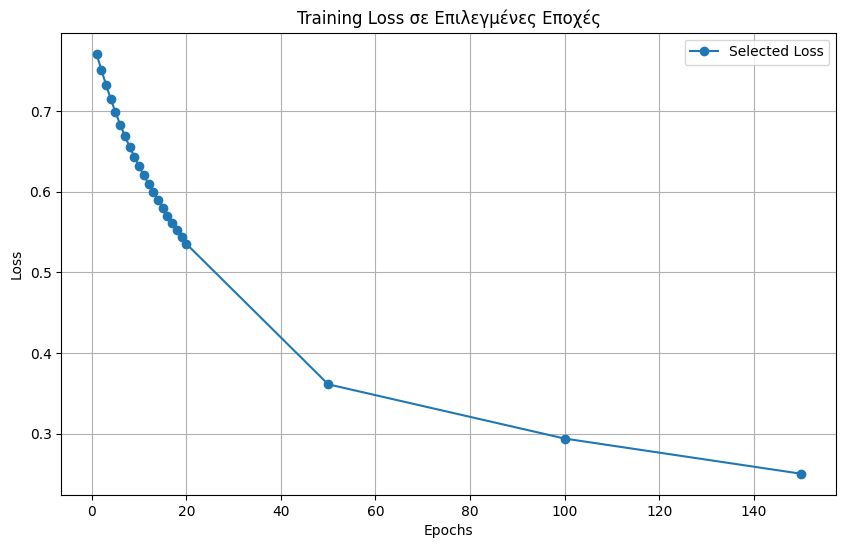

Ακρίβεια στο Training set: 90.09%
[[107   9]
 [ 12  84]]
Ακρίβεια στο Test set: 85.71%
[[40  8]
 [ 5 38]]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

train_data, train_labels = torch.tensor(X_train).float(), torch.tensor(y_train.reshape(-1, 1)).float()
test_data, test_labels = torch.tensor(X_test).float(), torch.tensor(y_test.reshape(-1, 1)).float()


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 5)
        self.fc2 = nn.Linear(5, 1)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x


model = MLP()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

selected_epochs = []
selected_losses = []


num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss = loss.item()


    if (epoch + 1) <= 20 or (epoch + 1) % 50 == 0:
        selected_epochs.append(epoch + 1)
        selected_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.8f}")


plt.figure(figsize=(10, 6))
plt.plot(selected_epochs, selected_losses, label="Selected Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss σε Επιλεγμένες Εποχές")
plt.legend()
plt.grid()
plt.show()


model.eval()

def predict_acc(data, labels, name):
    with torch.no_grad():
        outputs = model(data)
        predicted = (outputs >= 0.5).float()
        correct = (predicted == labels).sum().item()
        accuracy = accuracy_score(labels, predicted) * 100

    print(f'Ακρίβεια στο {name} set: {accuracy:.2f}%')
    print(confusion_matrix(labels, predicted))

    return predicted

predict_acc(train_data, train_labels, "Training")
predicted = predict_acc(test_data, test_labels, "Test")